In [1]:
from holisticai.utils.trade_off_analysers import Fairea

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from holisticai.datasets import load_adult
from sklearn.model_selection import train_test_split

# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

# Dataset
data = load_adult()
df = pd.concat([data["data"], data["target"]], axis=1)

def preprocess_adult_dataset(df):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()

  # Get the protected attribute vectors
  group_a = df_clean["sex"] == "Female"
  group_b = df_clean["sex"] == "Male"

  group_a = np.squeeze(group_a.values)
  group_b = np.squeeze(group_b.values)
  # Remove unnecessary columns
  df_clean["class"].replace({">50K": 1, "<=50K": 0}, inplace=True)
  tmp = pd.get_dummies(df_clean.drop(columns=["sex", "race", "education", "class"]))
  df_clean = pd.concat([tmp, df_clean["class"].astype("uint8")], axis=1)
  return df_clean, group_a, group_b

df_clean, group_a, group_b = preprocess_adult_dataset(df)

X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)

## Begin trade-off analysis with Fairea

In [3]:
fairea = Fairea(acc_metric='acc', fair_metric='aod', verbose=True)

### Create baseline and plot it

The first step involves a baseline construction. This is done by fitting a simple model which serves as a baseline, before the outputs are mutated to collect a set of trade-off points that will be used later to determine the mitigation regions for the model comparison. 

In [4]:
fairea.create_baseline(X_train, y_train, group_a_tr, group_b_tr)

Current datasplit: 0
Current datasplit: 1
Current datasplit: 2
Current datasplit: 3
Current datasplit: 4
Current datasplit: 5
Current datasplit: 6
Current datasplit: 7
Current datasplit: 8
Current datasplit: 9


<Axes: title={'center': 'Baseline Model'}, xlabel='Fairness', ylabel='Accuracy'>

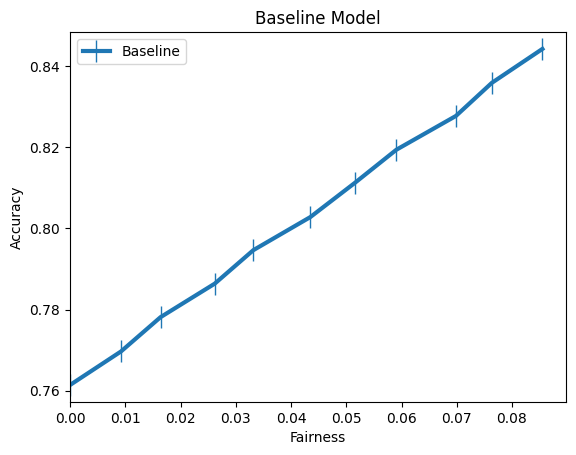

In [5]:
fairea.plot_baseline(title="Baseline Model", normalize=False)

### Add mitigation methods to the fairea object

In [6]:
# Preprocessing methods
from holisticai.bias.mitigation import CorrelationRemover

# Postprocessing methods
from holisticai.bias.mitigation import CalibratedEqualizedOdds

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [7]:
from holisticai.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", LogisticRegression()),
    ]
)

pipeline.fit(X_train, y_train, bm__group_a=group_a_tr, bm__group_b=group_b_tr)

y_pred = pipeline.predict(X_test, bm__group_a=group_a_ts, bm__group_b=group_b_ts)

In [8]:
fairea.add_model_outcomes("CorrelationRemover", y_test, y_pred, group_a_ts, group_b_ts)

In [9]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("estimator", LogisticRegression()),
        ("bm_postprocessing", CalibratedEqualizedOdds(cost_constraint="fnr")),
    ]
)

pipeline.fit(X_train, y_train, bm__group_a=group_a_tr, bm__group_b=group_b_tr)

y_pred = pipeline.predict(X_test, bm__group_a=group_a_ts, bm__group_b=group_b_ts)

In [10]:
fairea.add_model_outcomes("CalibratedEqualizedOdds", y_test, y_pred, group_a_ts, group_b_ts)

<Axes: title={'center': 'Baseline Model with Mitigators'}, xlabel='Fairness', ylabel='Accuracy'>

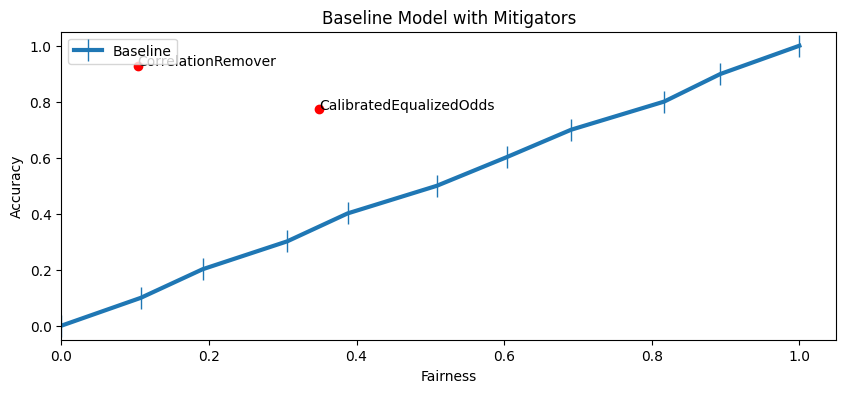

In [11]:
fairea.plot_methods(title="Baseline Model with Mitigators", normalize=True, figsize=(10, 4))

### Determine the region for the methods

Once the baseline has been created, and the mitigation methods have been added, the approach categorises the mitigator models into five regions that represent the effectiveness of the bias mitigation. These regions are:

- "Win-win": when a method improves the accuracy and reduces bias with respect to the original model.
- "Lose-lose": when a method reduces the accuracy and increases bias with respect to the original model.
- "Inverted trade-off": When a method improves accuracy but increases bias.
- "Good trade-off": when a method reduces bias and decreases accuracy but achieves a better trade-off than the baseline.
- "Poor trade-off": When a method reduces bias and decreases accuracy but achieves a lower trade-off than the baseline.

In [12]:
fairea.trade_off_region_classification()

,Region
CorrelationRemover,good trade-off
CalibratedEqualizedOdds,good trade-off


### Calculate area for "good trade-off" methods

After the mitigators have been categorised, the effectiveness of the methods is measured. Given that the win-win, lose-lose, inverted trade-off and the poor trade-off regions provide clear signals about how the mitigator performs, this measurement is focused on the mitigators that fall into the good trade-off region.

This is achieved by calculating the area that results by projecting a horizontal and a vertical line from the mitigator position to the trade-off points of the baseline. This area represents the strength of the fairness-accuracy trade-off. Therefore, the larger the area is, the better the fairness-accuracy trade-off.

In [13]:
fairea.compute_trade_off_area()

,Area
CorrelationRemover,0.340611
CalibratedEqualizedOdds,0.089077


### Get best model

As we can see, the model that presents a better trade-off is the Correlation Remover method, since it presents a larger area in comparison with the Calibrated Equalized odds method.

In [14]:
fairea.get_best_model()

'CorrelationRemover'